<a href="https://colab.research.google.com/github/Lukebotbol/MSc_Thesis_Abstractive_Summarization/blob/main/Abstractive_Summarization_Pegasus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Set-up

In [ ]:
# only run this cell if you are in collab
!pip install ohmeow-blurr -q
!pip install datasets -q
!pip install bert-score -q

     |████████████████████████████████| 75 kB 3.2 MB/s 
     |████████████████████████████████| 2.6 MB 17.0 MB/s 
     |████████████████████████████████| 43 kB 2.5 MB/s 
     |████████████████████████████████| 542 kB 45.2 MB/s 
     |████████████████████████████████| 1.2 MB 35.8 MB/s 
     |████████████████████████████████| 188 kB 75.2 MB/s 
     |████████████████████████████████| 53 kB 2.9 MB/s 
     |████████████████████████████████| 636 kB 53.5 MB/s 
     |████████████████████████████████| 895 kB 54.9 MB/s 
     |████████████████████████████████| 3.3 MB 48.2 MB/s 
     |████████████████████████████████| 76 kB 5.5 MB/s 
     |████████████████████████████████| 118 kB 69.0 MB/s 
     |████████████████████████████████| 243 kB 66.6 MB/s 
     |████████████████████████████████| 59 kB 4.3 MB/s 


In [ ]:
import datasets
import pandas as pd
from fastai.text.all import *
from transformers import *

from blurr.data.all import *
from blurr.modeling.all import *

In [ ]:
import torch
from transformers import *
from fastai.text.all import *

from blurr.utils import *
from blurr.data.core import get_blurr_tfm
from blurr.data.seq2seq.core import *
from blurr.data.seq2seq.summarization import *
from blurr.modeling.core import *
from blurr.modeling.seq2seq.core import *

In [ ]:
#hide
import pdb
from fastcore.test import *

from fastai import __version__ as fa_version
from torch import __version__ as pt_version
from transformers import __version__ as hft_version

print(f'Using pytorch {pt_version}')
print(f'Using fastai {fa_version}')
print(f'Using transformers {hft_version}')

Using pytorch 1.9.0+cu102
Using fastai 2.4.1
Using transformers 4.9.1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Preparation

In [ ]:
raw_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset(1).csv')

In [ ]:
df = raw_data
df_train = raw_data[:int(len(df) * 0.8)]
df_test = raw_data[int(len(df) * 0.8):]
df.head()

,Unnamed: 0,index,doc,id,original_text,reference_summary,title,uid,case_code,case_text,note,title_code,title_text,urls,tldr_code,tldr_text
0,0,legalsum01,Pokemon GO Terms of Service,5786730a6cca83a54c0035b7,welcome to the pokémon go video game services which are accessible via the niantic inc niantic mobile device application the app. to make these pokémon go terms of service the terms easier to read our video game services the app and our websites located at http pokemongo nianticlabs com and http www pokemongolive com the site are collectively called the services. please read carefully these terms our trainer guidelines and our privacy policy because they govern your use of our services.,please read carefully these terms our trainer guidelines and our privacy policy because they govern your use of our services.,NaN,legalsum01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,legalsum02,Pokemon GO Terms of Service,57866df76cca83a54c0035a1,by using our services you are agreeing to these terms our trainer guidelines and our privacy policy. if you are the parent or legal guardian of a child under the age of 13 the parent you are agreeing to these terms on behalf of yourself and your child ren who are authorized to use the services pursuant to these terms and in our privacy policy. if you don t agree to these terms our trainer guidelines and our privacy policy do not use the services.,by playing this game you agree to these terms. if you re under 13 and playing your parent guardian agrees on your behalf.,Agreement To Terms,legalsum02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,legalsum03,Pokemon GO Terms of Service,5786730a6cca83a54c0035b6,if you want to use certain features of the services you will have to create an account with us an account. you can create an account if you have a a pre existing google account b a pre existing pokémon trainer club ptc account c a pre existing account with facebook or d such other pre existing third party accounts as we may choose to support in the future notification of which will be provided by allowing selection of such pre existing accounts on the relevant account creation screen. we will create your account by extracting from your google ptc facebook or other pre existing third party ...,you have to use google pokemon trainer club or facebook to sign up and play. if you re under 13 your parent guardian has to do this for you. we might ban your account if your information is inaccurate.,Eligibility and Account Registration,legalsum03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,legalsum04,Pokemon GO Terms of Service,57866df76cca83a54c0035a0,during game play please be aware of your surroundings and play safely. you agree that your use of the app and play of the game is at your own risk and it is your responsibility to maintain such health liability hazard personal injury medical life and other insurance policies as you deem reasonably necessary for any injuries that you may incur while using the services. you also agree not to use the app to violate any applicable law rule or regulation including but not limited to the laws of trespass or the trainer guidelines and you agree not to encourage or enable any other individual to v...,you agree that your use of the app and play of the game is at your own risk and it is your responsibility to maintain such health liability hazard personal injury medical life and other insurance policies as you deem reasonably necessary for any injuries that you may incur while using the services,Safe Play,legalsum04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,legalsum05,Pokemon GO Terms of Service,57866df76cca83a54c00359f,subject to your compliance with these terms niantic grants you a limited nonexclusive nontransferable non sublicensable license to download and install a copy of the app on a mobile device and to run such copy of the app solely for your own personal noncommercial purposes. except as expressly permitted in these terms you may not a copy modify or create derivative works based on the ap

In [ ]:
pretrained_model_name = "sshleifer/distill-pegasus-cnn-16-4"
hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(pretrained_model_name, 
                                                                  model_cls=AutoModelForSeq2SeqLM)

hf_arch, type(hf_config), type(hf_tokenizer), type(hf_model)

Downloading:   0%|          | 0.00/1.16k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.48G [00:00<?, ?B/s]

('pegasus',
 transformers.models.pegasus.configuration_pegasus.PegasusConfig,
 transformers.models.pegasus.tokenization_pegasus_fast.PegasusTokenizerFast,
 transformers.models.pegasus.modeling_pegasus.PegasusForConditionalGeneration)

Next we need to build out our DataBlock.

In [ ]:
text_gen_kwargs = default_text_gen_kwargs(hf_config, hf_model, task='summarization'); text_gen_kwargs

{'bad_words_ids': None,
 'bos_token_id': 0,
 'decoder_start_token_id': 0,
 'diversity_penalty': 0.0,
 'do_sample': False,
 'early_stopping': False,
 'encoder_no_repeat_ngram_size': 0,
 'eos_token_id': 1,
 'forced_bos_token_id': None,
 'forced_eos_token_id': 1,
 'length_penalty': 0.8,
 'max_length': 128,
 'min_length': 0,
 'no_repeat_ngram_size': 0,
 'num_beam_groups': 1,
 'num_beams': 8,
 'num_return_sequences': 1,
 'output_attentions': False,
 'output_hidden_states': False,
 'output_scores': False,
 'pad_token_id': 0,
 'remove_invalid_values': False,
 'repetition_penalty': 1.0,
 'return_dict_in_generate': False,
 'temperature': 1.0,
 'top_k': 50,
 'top_p': 1.0,
 'use_cache': True}

In [ ]:
hf_batch_tfm = HF_Seq2SeqBeforeBatchTransform(hf_arch, hf_config, hf_tokenizer, hf_model, 
                                              max_length=256, max_tgt_length=130, text_gen_kwargs=text_gen_kwargs)

blocks = (HF_Seq2SeqBlock(before_batch_tfm=hf_batch_tfm), noop)

dblock = DataBlock(blocks=blocks, get_x=ColReader('original_text'), get_y=ColReader('reference_summary'), splitter=RandomSplitter())

In [ ]:
dls = dblock.dataloaders(df_train, bs=2)

In [ ]:
test_dl = dls.test_dl(df_test, with_labels=True)

In [ ]:
len(dls.train.items), len(dls.valid.items), len(test_dl.items)

(285, 71, 90)

In [ ]:
#Cheking batch
b = dls.one_batch()
len(b), b[0]['input_ids'].shape, b[1].shape

(2, torch.Size([2, 256]), torch.Size([2, 44]))

In [ ]:
dls.show_batch(dataloaders=dls, max_n=3)

,text,target
0,governing lawthese terms and any action related thereto will be governed by the laws of the state of california without regard to its conflict of laws provisions. agreement to arbitrateyou and niantic agree that any dispute claim or controversy arising out of or relating to these terms or the breach termination enforcement interpretation or validity thereof or the use of the services or content collectively disputes will be settled by binding arbitration except that each party retains the right a to bring an individual action in small claims court and b to seek injunctive or other equitable relief in a court of competent jurisdiction to prevent the actual or threatened infringement misappropriation or violation of a party s copyrights trademarks trade secrets patents or other intellectual property rights the action described in this clause b an ip protection action. without limiting the preceding sentence you will also have the right to litigate any other dispute if you provide niantic with written notice of your desire to do so by email or regular mail at termsofservice nianticlabs com or 2 bryant st ste. 220 san francisco ca 94105 within thirty 30 days following the date you first accept these terms such notice an arbitration opt out notice. if you don t provide niantic with an arbitration opt out notice within the thirty 30 day period you will be deemed to</s>,if you have issues with these terms you agree to use an independent party to settle it with us instead of suing us. if it s really serious or you write us in advance you can sue us.
1,you agree that you are responsible for your own conduct and user content while using the services and for any consequences thereof. please refer to our trainer guidelines https pokemongo nianticlabs com support guidelines en for information about the kinds of conduct and user content that are prohibited while using the services. by way of example and not as a limitation you agree that when using the services and content you will not defame abuse harass harm stalk threaten or otherwise violate the legal rights including the rights of privacy and publicity of others upload post email transmit or otherwise make available any unlawful inappropriate defamatory obscene pornographic vulgar offensive fraudulent false misleading or deceptive content or message promote or engage in discrimination bigotry racism hatred or harassment against any individual or group trespass or in any manner attempt to gain or gain access to any property or location where you do not have a right or permission to be violate or encourage any conduct that would violate any applicable law or regulation or would give rise to civil liability upload post or otherwise make available commercial messages or advertisements pyramid schemes or other disruptive notices impersonate or misrepresent your affiliation with another person or entity promote or provide instructional information about illegal or harmful activities or substances promote or engage in physical harm violence or injury against any group or individual transmit any viruses worms defects trojan horses or any items of a destructive nature submit fake</s>,don t hack or cheat. we don t have to ban you but we can. we ll also cooperate with law enforcement.


## Training

In [ ]:
#Setting metrics
seq2seq_metrics = {
        'rouge': {
            'compute_kwargs': { 'rouge_types': ["rouge1", "rouge2", "rougeL"], 'use_stemmer': True },
            'returns': ["rouge1", "rouge2", "rougeL"]
        }
    }

In [ ]:
model = HF_BaseModelWrapper(hf_model)
learn_cbs = [HF_BaseModelCallback]
fit_cbs = [HF_Seq2SeqMetricsCallback(custom_metrics=seq2seq_metrics), EarlyStoppingCallback(monitor='valid_loss', min_delta=0.001, patience=2)]

learn = Learner(dls, 
                model,
                opt_func=ranger,
                loss_func=CrossEntropyLossFlat(),
                cbs=learn_cbs,
                splitter=partial(seq2seq_splitter, arch=hf_arch)).to_fp16()

learn.create_opt() 
learn.freeze()

In [ ]:
b = dls.one_batch()
preds = learn.model(b[0])
len(preds),preds[0], preds[1].shape

(4,
 tensor(7.1990, device='cuda:0', grad_fn=<NllLossBackward>),
 torch.Size([2, 42, 96103]))

In [ ]:
learn.fit_one_cycle(14, lr_max=3e-5, cbs=fit_cbs)

epoch,train_loss,valid_loss,rouge1,rouge2,rougeL,time
0,5.871009,5.570263,0.255816,0.090840,0.215257,00:53
1,5.675912,5.303351,0.285031,0.111159,0.243103,00:48
2,5.266609,5.031439,0.283366,0.098036,0.238375,00:45
3,5.001255,4.834930,0.271365,0.100980,0.232210,00:45
4,5.091191,4.704089,0.269358,0.099915,0.232426,00:42
5,4.858624,4.617717,0.276870,0.103756,0.236401,00:43
6,4.801438,4.548277,0.277929,0.100992,0.235713,00:43
7,4.704886,4.503864,0.282469,0.109840,0.242909,00:43
8,4.477115,4.473236,0.286600,0.110274,0.244841,00:43
9,4.397336,4.451594,0.287930,0.110146,0.247932,00:44


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


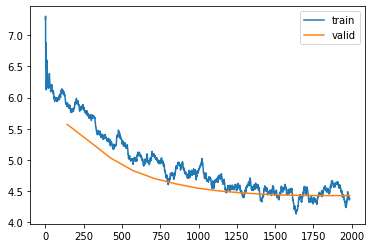

In [ ]:
#Validation loss
learn.recorder.plot_loss(skip_start=0, with_valid=True)

In [ ]:
for m in learn.metrics:
  print(f'{m.name}: {m.value *100}')

rouge1: 28.72698529652852
rouge2: 11.03207739709636
rougeL: 24.660393814562536


And now we can look at the generated predictions using our `text_gen_kwargs` above

In [ ]:
learn.show_results(learner=learn, max_n= 10)

,text,target,prediction
0,subject to your compliance with these terms niantic grants you a limited nonexclusive nontransferable non sublicensable license to download and install a copy of the app on a mobile device and to run such copy of the app solely for your own personal noncommercial purposes. except as expressly permitted in these terms you may not a copy modify or create derivative works based on the app b distribute transfer sublicense lease lend or rent the app to any third party c reverse engineer decompile or disassemble the app or d make the functionality of the app available to multiple users through any means. niantic reserves all rights in and to the app not expressly granted to you under these terms. if you accessed or downloaded the app from the apple store then you agree to use the app only a on an apple branded product or device that runs ios apple s proprietary operating system software and b as permitted by the usage rules set forth in the apple store terms of service. if you accessed or downloaded the app from any app store or distribution platform like the apple store google play or amazon appstore each an app provider then you acknowledge and agree that these terms are concluded between you and niantic and not with app provider and that as between us and the app provider niantic is solely responsible for the,don t copy modify resell distribute or reverse engineer this app.,niantic grants you a limited nonexclusive non-exclusive non-licensable license to download and install a copy of the app on a mobile device and to run such copy of the app solely for your own personal purposes.
1,for qwant and qwant junior accounts your data is removed 7 days after you request that the account be deleted. if you use a edu qwant junior account edu qwantjunior com your data is removed 3 months after the account deletion request. during this period you can ask that your account be reactivated using your initial username and password. for data that may be collected when you exercize some rights access opposition rectification right to be forgotten the duration of retention depends on what the law prescribes for each of these rights. please refer to the next section of this privacy policy for details. for connection data that the information system security department may access the duration of retention is 6 months. for qwant boards french law makes it mandatory to keep some connection data e g. user id used url or position nature of the operation time for one year. as the name says the right to oppose allows you to oppose data processing by qwant. you may for instance choose to delete your account. you can ask us if we have any information related to you and ask us information regarding their processing for instance the categories of data we process. this right allows you to ask qwant to give you all this information.,you can request access and deletion of personal data.,if you use a edu qwant junior account edu qwant com your data is removed 3 months after the deletion request. for connection data that the information system security department may access the duration of retention depends on what the law prescribes for each of these rights.


# Evaluation Test

In [ ]:
learn.validate(dl=test_dl, cbs=[HF_Seq2SeqMetricsCallback(custom_metrics=seq2seq_metrics)])

(#7) [4.255488872528076,0.28726985296528523,0.1103207739709636,0.24660393814562537,0.30079414479164346,0.1294475511700106,0.2685179722473191]

In [ ]:
for m in learn.metrics:
  print(f'{m.name}: {m.value *100}')

rouge1: 28.72698529652852
rouge2: 11.03207739709636
rougeL: 24.660393814562536
rouge1: 30.079414479164345
rouge2: 12.944755117001062
rougeL: 26.85179722473191


Inference

In [ ]:
learn.metrics = None
learn.export(fname='/content/drive/MyDrive/Colab Notebooks/pegasus_model.pkl')

In [ ]:
inf_learn = load_learner(fname='/content/drive/MyDrive/Colab Notebooks/pegasus_model.pkl')
inf_learn.blurr_generate(test_article)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


['niantic grants you a limited nonexclusive non-exclusive non-licensable license to download and install a copy of the app on a mobile device and to run such copy of the app solely for your own personal purposes.']